In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as sio
from scipy.ndimage import binary_opening, binary_closing, gaussian_filter1d as gauss_filter
from scipy.signal import resample

%matplotlib nbagg

In [2]:
def apply_to_stretched_out(fun,loc_in,buffer=10):
    """        
        method to apply some function to location data which is not interrupted by teleports.
        this avoid weird behavior when averaging, taking median, etc
    """
    
    loc = loc_in.copy()
    max_val = np.max(loc)
    min_val = np.min(loc)

    total_distance = max_val - min_val

    ## identify and remove teleports
    idx_teleport = np.where(np.diff(loc)<-total_distance/2)[0]
    for idx_tp in idx_teleport:
        loc[idx_tp+1:] = loc[idx_tp+1:] + total_distance + buffer

    ## apply function
    loc = fun(loc)

    ## reintroduce teleports
    loc = np.mod(loc-min_val+buffer/2,total_distance+buffer)+min_val

    return loc

In [3]:
#session = 50# @ 2 there's a mismatch in shapes during alignment
#33 2

In [269]:
def is_rw_col(data,time):
    """
        behavior data is not stored homogeneously across all experiments, but may contain 
        reward data in different columns (3 or 8). This function attempts to identify the
        reward column by 3 criteria:
            - number of reward events (maximum of one per trial):
                assuming around 10 secs per trial, the number of reward events shouldnt surpass T/10
            - time between rewards:
                this should not go much beneath 10 secs (here min 5 secs)
            - reward deliveries per trial
                there should be at most 3 reward deliveries per reward event
    """
    rw_max_num = (time[-1]/10.)*1.1
    
    rw_tmp = np.array(data)>0.5
    rw_tmp_closed = binary_closing(rw_tmp,np.ones(100))
    rw_start = np.where(np.diff(rw_tmp.astype('int'))==1)[0]
    rw_start_closed = np.where(np.diff(rw_tmp_closed.astype('int'))==1)[0]

    dTime = np.array(time)[rw_start_closed]
    ratio = len(rw_start)/len(rw_start_closed)
    
    return (len(rw_start_closed) < rw_max_num) and (np.min(dTime)>5) and ratio < 4
    

def load_behavior_data(ssh_alias='transfer-gwdg',
                       data_path='/usr/users/cidbn1/neurodyn/AlzheimerMice_Hayashi',
                       mouse='556wt',session=50,
                       rw_col=None,mic_col=None,
                       speed_gauss_sd=5):
    
    """
        this function loads behavioral data either from .txt-, or from .mat-file
        Files are loaded according to file-structure, with notable differences in some mice:
            - mic_col: [None or 8] (default: None)
                the column that contains data on whether recording 
                was active or not during frame, sometimes not present
            - rw_col: [None, 3 or 8] (default: None)
                the column that contains data on whether a reward was
                delivered during frame. If 'None', column is inferred from data
    """
    rw_col_candidates = [3,8]
    
    tmp_path = "./tmp/behavior"
    ext = 'txt'
    bh_path = os.popen(f"ssh {ssh_alias} find {data_path}/{mouse}/Session{session:02}/a* -maxdepth 0 -type f").read()

    if not len(bh_path):
        ext = 'mat'
        bh_path = os.popen(f"ssh {ssh_alias} find {data_path}/{mouse}/Session{session:02}/crop* -maxdepth 0 -type f").read()

    tmp_path = f"{tmp_path}.{ext}"
    
    cmd = f"scp {ssh_alias}:{bh_path[:-1]} {tmp_path} > /dev/null"
    os.system(cmd)
    

    if ext=='txt':

        data_tmp = pd.read_csv(tmp_path,sep='\t')
        
        ## in some of the .txt files, column header is f**cked up
        if not ('Microscope' in data_tmp.keys()):
            data_tmp.reset_index(inplace=True)
            data_tmp.drop('level_0',axis=1,inplace=True)
            cols = list(data_tmp.columns[1:-1])
            cols.extend(['Microscope','Licking'])
            
            col_dict = {}
            for key_ref,key in zip(data_tmp.columns,cols):
                col_dict[key_ref] = key
            data_tmp.rename(columns=col_dict,inplace=True)
        cols = data_tmp.columns
                
        ## find fitting reward column
        if not rw_col:
            for col in rw_col_candidates:
                looks_like_it = is_rw_col(data_tmp[cols[col-1]],data_tmp['Time'])
                if looks_like_it:
                    rw_col = col
                    break
        if not rw_col:
            raise RuntimeError('No reward column could be found')


        cols = data_tmp.columns
            
        data = {
            'time': np.array(data_tmp['Time']),
            'speed': np.array(data_tmp['Speed']),
            'reward': np.array(data_tmp[cols[rw_col-1]])>0.5,
            'frame': np.array(data_tmp['Frame#']).astype('int'),
            'loc': np.array(data_tmp['omegaY'])
        }
        if mic_col:
            data['recording'] = binary_closing(data_tmp[cols[mic_col]]<1,np.ones(5))
        else:
            idx_start = np.where(data['frame']==1)[0][0]
            idx_end = np.where(data['frame']==8989)[0][0]+3
            data['recording'] = np.zeros_like(data['frame'],'bool')
            data['recording'][idx_start:idx_end+1] = True

    else:
        data_tmp = sio.loadmat(tmp_path)
        data_tmp = data_tmp['crop_bhdata']
        
        ## find fitting reward column
        if not rw_col:
            for col in rw_col_candidates:
                looks_like_it = is_rw_col(data_tmp[:,col],data_tmp[:,1])
                if looks_like_it:
                    rw_col = col
                    break
        if not rw_col:
            raise RuntimeError('No reward column could be found')
        
        data = {
            'time': data_tmp[:,1],
            'speed': data_tmp[:,2],
            'reward': data_tmp[:,rw_col]>0.5,
            'frame': data_tmp[:,4].astype('int'),
            'loc': data_tmp[:,6]
        }
        if mic_col:
            data['recording'] = binary_closing(data_tmp[:,mic_col]<1,np.ones(5))
        else:
            idx_start = np.where(data['frame']==1)[0][0]
            idx_end = min(np.where(data['frame']==8989)[0][0]+4,np.where(data['frame']==8989)[0][-1])
            data['recording'] = np.zeros_like(data['frame'],'bool')
            data['recording'][idx_start:idx_end+1] = True

    data['speed'] = gauss_filter(data['speed'],speed_gauss_sd)
    
    return data, rw_col

In [270]:
data,rw_col = load_behavior_data(mouse='556wt',session=49,speed_gauss_sd=3)

find: /usr/users/cidbn1/neurodyn/AlzheimerMice_Hayashi/556wt/Session49/a*: Datei oder Verzeichnis nicht gefunden


In [271]:
data['frame'][data['recording']]

array([   1,    1,    1, ..., 8989, 8989, 8989])

<IPython.core.display.Javascript object>


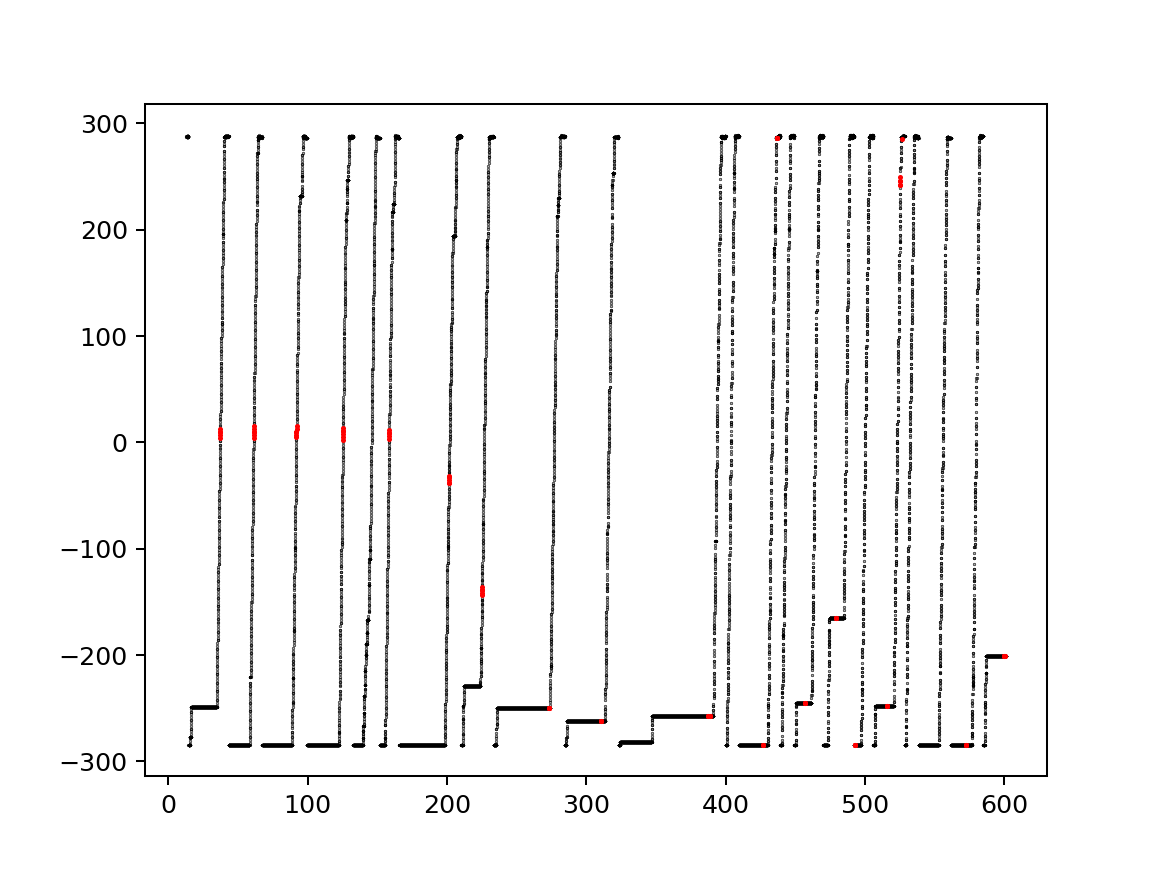

In [228]:
plt.figure()
plt.plot(data['time'],data['loc'],'k.',ms=0.5)
plt.plot(data['time'][data['reward']],data['loc'][data['reward']],'r.',ms=2)

plt.show()

In [318]:
## shift @s=35

def align_behavior_data(data,rw_delay=0,align_tolerance=5,rw_tolerance=5,loc_buffer=10):

    rw_tmp = binary_closing(data['reward'],np.ones(100))

    ## get positions at which reward is delivered, and where mouse passes through rw location (should be aligned)
    idxs_reward_delivery = np.where(np.diff(rw_tmp.astype('int'))==1)[0]
    
    ## identify location of reward
    rw_loc_candidates = [-150,0,150]
    rw_loc = np.mean(data['loc'][idxs_reward_delivery[:3]])
    idx_rw_loc = np.argmin(np.abs(rw_loc_candidates - rw_loc))
    rw_loc = rw_loc_candidates[idx_rw_loc]
    
    idxs_reward_passthrough = np.where(np.diff((data['loc']>rw_loc).astype('int'))==1)[0] + 1
    
    loc_aligned = np.zeros_like(data['loc'])

    idx_rwd_prev = 0
    idx_rwpt_prev = 0

    loc_dist = np.max(data['loc']) - np.min(data['loc']) + loc_buffer

    data['time'] -= data['time'][data['recording']][0]
    data_aligned = data.copy()

    ## instead of assigning each pass to each reward, find proper fitting index
    n_passthrough = 0
    end_reached = False
    for idx_rwd in idxs_reward_delivery:

        ## find fitting passthrough index
        idx_match = False
        while not idx_match:
            if n_passthrough==len(idxs_reward_passthrough):
                end_reached = True
                break
            else:
                idx_rwpt = idxs_reward_passthrough[n_passthrough]
                if (not idx_rwd_prev==0) and (idx_rwpt-idx_rwpt_prev)<0.9*(idx_rwd-idx_rwd_prev):
                    n_passthrough += 1
                else:
                    idx_match = True
        if end_reached:
            break

        ### now, find loc of this trial, where mouse passes through rw-zone
        if (abs(idx_rwpt-idx_rwd) > align_tolerance) & \
            ((rw_loc-rw_tolerance > data['loc'][idx_rwd]) | (rw_loc+rw_tolerance < data['loc'][idx_rwd])):

            ## align location
            loc_aligned[idx_rwd_prev:idx_rwd] = apply_to_stretched_out(
                lambda x: resample(x,idx_rwd-idx_rwd_prev),
                data['loc'][idx_rwpt_prev:idx_rwpt],
                buffer=loc_buffer
            )

            idx_rwpt_prev = idx_rwpt
            idx_rwd_prev = idx_rwd
        else:
            ## merely copy over raw data
            if (idx_rwpt_prev==idx_rwd_prev):
                loc_aligned[idx_rwd_prev:idx_rwd] = data['loc'][idx_rwpt_prev:idx_rwd]
            else:
                loc_aligned[idx_rwd_prev:idx_rwd] = resample(data['loc'][idx_rwpt_prev:idx_rwpt],idx_rwd-idx_rwd_prev)

            idx_rwpt_prev = idx_rwd
            idx_rwd_prev = idx_rwd

    # when last index is reached, attach remaining location data
    dT_end = min(len(data['loc'])-idx_rwpt,len(loc_aligned) - idx_rwd_prev)
    loc_aligned[idx_rwd_prev:idx_rwd_prev+dT_end] = data['loc'][idx_rwpt_prev:idx_rwpt_prev+dT_end]
    loc_aligned[idx_rwd_prev+dT_end:] = np.nan
    data_aligned['loc'] = loc_aligned
    return data_aligned, rw_loc
    
    

    #print('location:',loc[trial[0]])
    #if (rw_loc-5 > loc[trial[0]]) | (rw_loc+5 < loc[trial[0]]):
    #    print('this trial is misaligned! (loc)',trial)
    
    ### take previous rw_start as start and rw-pass through as end
    ### stretch / compress location data accordingly, to align rw_start with rw_passthrough


def resample_behavior_data(data,T=8989,nbins=100,loc_buffer=10,speed_thr=2.,speed_gauss_sd=4,binary_morph_width=5):
    
    """
        Function to resample the data to T frames
        This function also creates binned location
    """
    
    min_val,max_val = np.percentile(data['loc'],(0.1,99.9))
    
    ## remove outliers (sometimes come in through resampling or other weird stuff)
    data['loc'][data['loc']<min_val] = min_val
    data['loc'][data['loc']>max_val] = max_val
    
    #min_val = np.nanmin(data['loc'])
    #max_val = np.nanmax(data['loc'])
    
    loc_dist = max_val - min_val + loc_buffer
    
    for key in ['time','loc','speed','frame','reward']:
        data[key] = data[key][data['recording']]

    loc_tmp = data['loc'].copy() - min_val
    trial_idx = np.where(np.diff(loc_tmp)<(-loc_dist/2))[0]
    for idx in trial_idx:
        loc_tmp[idx+1:] = loc_tmp[idx+1:] + loc_dist

    data_resampled = {
        'frame': np.linspace(0,T,T),
        'time': np.zeros(T),
        'loc': np.zeros(T),
        'speed': np.zeros(T),
        'reward': np.zeros(T,dtype='bool'),
    }
    
    fs = np.unique(data['frame'])
    for f in range(T):
        if f in fs:
            data_resampled['loc'][f-1] = np.median(loc_tmp[data['frame']==f])
            data_resampled['time'][f-1] = np.median(data['time'][data['frame']==f])
            data_resampled['reward'][f-1] = np.any(data['reward'][data['frame']==f])
            data_resampled['speed'][f-1] = np.mean(data['speed'][data['frame']==f])
        else:
            data_resampled['loc'][f-1] = np.median(loc_tmp[data['frame']==f-1])
            data_resampled['time'][f-1] = np.median(data['time'][data['frame']==f-1])
            data_resampled['reward'][f-1] = np.any(data['reward'][data['frame']==f-1])
            data_resampled['speed'][f-1] = np.mean(data['speed'][data['frame']==f-1])

    data_resampled['loc'] = np.mod(data_resampled['loc']+loc_buffer/2,loc_dist)
    data_resampled['bins'] = (data_resampled['loc'] / (max_val - min_val) * nbins)#.astype('int')
    
    speed2 = gauss_filter(np.maximum(0,np.diff(data_resampled['loc'],prepend=data_resampled['loc'][0])),speed_gauss_sd)
    inactive = np.logical_or(
        data_resampled['speed'] <= speed_thr, 
        speed2 <= speed_thr
    )
    inactive = binary_opening(inactive,np.ones(binary_morph_width))
    data_resampled['active'] = ~inactive
    
    return data_resampled

In [299]:
data_align, rw_loc = align_behavior_data(data)

In [313]:
minval,maxval = np.percentile(data_align['loc'],(0.1,99.9))

-285.0

In [303]:
### plotting
def plot_mouse_location(ax,data,rw_loc=0,loc_buffer=10):
    
    loc = data['bins'] if 'bins' in data.keys() else data['loc']
    min_val = np.nanmin(loc)
    max_val = np.nanmax(loc)

    loc_dist = max_val - min_val + loc_buffer
    
    
    # identify location of trial-starts
    trial_idx = np.where(np.diff(loc)<(-loc_dist/2))[0]
    for idx in trial_idx:
        ax.axvline(data['time'][idx],color='b',lw=0.5)

    ax.axhline(rw_loc,color='k',ls='--',lw=0.5)
    ax.plot(data['time'],loc,'k.',ms=0.5,label='active')
    # idxs_reward_delivery = np.where(np.diff(data['reward'].astype('int'))==1)[0]
    # ax.plot(data['time'][idxs_reward_delivery],data['loc'][idxs_reward_delivery],'b.',ms=5)
    
    if 'active' in data.keys():
        ax.plot(data['time'][~data['active']],loc[~data['active']],'r.',ms=.5,label='inactive')
    ax.plot(data['time'][data['reward']],loc[data['reward']],'b.',ms=5,label='reward')
    

In [250]:
data['frame']

array([   1,    1,    1, ..., 8989, 8989, 8990])

-285.0 289.0963911648554


/home/wollex/Data/Programmes/anaconda3/envs/caiman/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wollex/Data/Programmes/anaconda3/envs/caiman/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


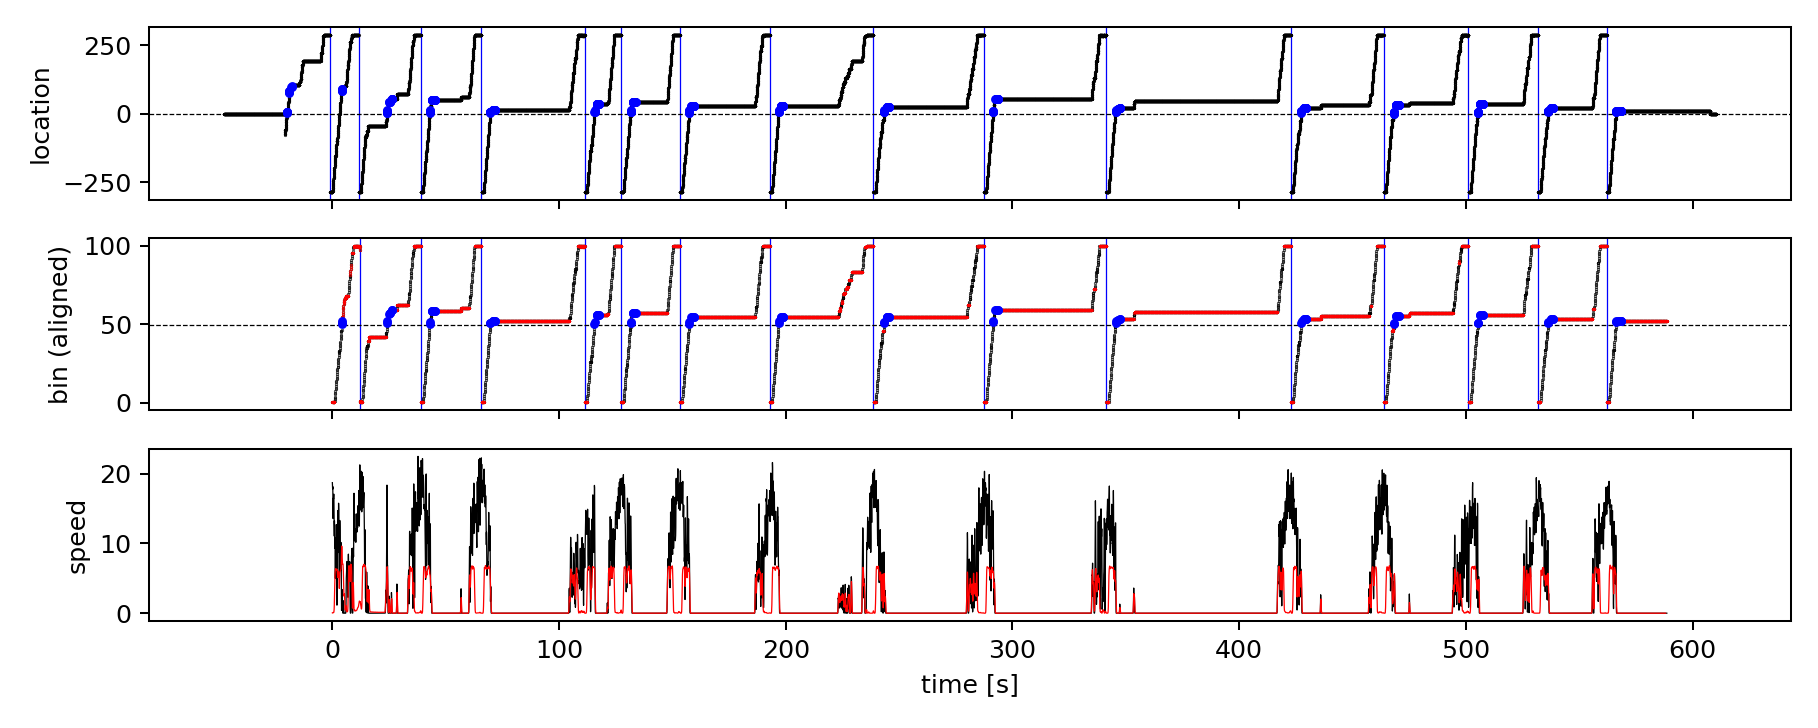

In [317]:
#rw_loc = 150
rw_delay = 0

T = 8989
nbins = 100

mouse='875ad'
session=12
data, rw_col = load_behavior_data(mouse=mouse,session=session,speed_gauss_sd=3)

data_align, rw_loc = align_behavior_data(data,loc_buffer=2)
data_resampled = resample_behavior_data(data_align,T,nbins,loc_buffer=2,speed_gauss_sd=2,speed_thr=2,binary_morph_width=5)

fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,4))

plot_data(ax[0],data,rw_loc)
plt.setp(ax[0],ylabel='location')

rw_loc_bins = (rw_loc-np.min(data['loc'])) / (np.max(data['loc']) - np.min(data['loc'])) * nbins
plot_data(ax[1],data_resampled,rw_loc_bins)
plt.setp(ax[1],ylabel='bin (aligned)')

ax[2].plot(data_resampled['time'],data_resampled['speed'],'k-',lw=0.5)
speed2 = gauss_filter(np.maximum(0,np.diff(data_resampled['loc'],prepend=data_resampled['loc'][0])),2)
ax[2].plot(data_resampled['time'],speed2,'r-',lw=0.5)
plt.setp(ax[2],ylabel='speed',xlabel='time [s]')

#plt.setp(ax[2],xlim=[500,560])
plt.tight_layout()
plt.savefig(f'aligned_m={mouse}_s={session:02}__reward_col={rw_col}_loc={rw_loc}.png',dpi=150)
plt.show()

In [293]:
rw_col, rw_loc

(3, 0)

<IPython.core.display.Javascript object>


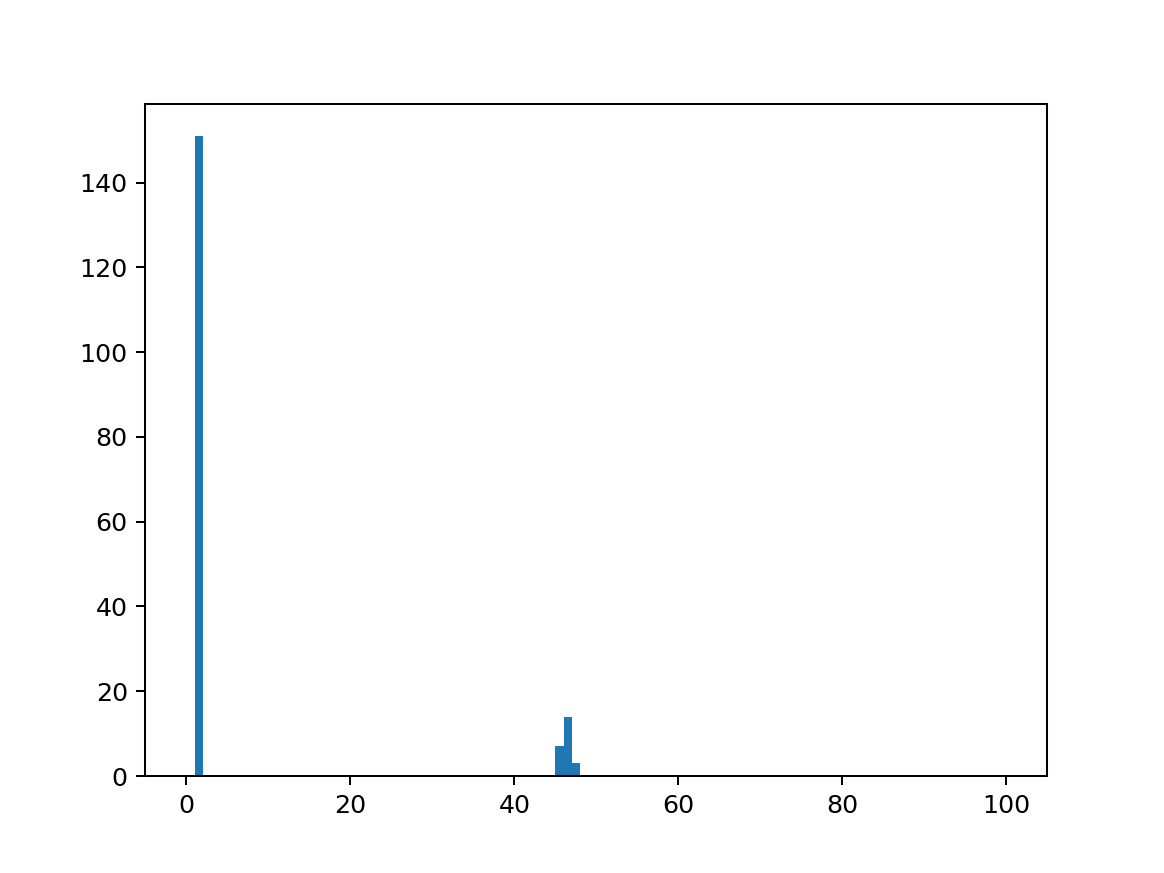

(array([  0., 151.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   7.,  14.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  4

In [181]:
fig,ax = plt.subplots(1,1)
#ax.hist(np.diff(np.where(reward)[0]),bins=np.logspace(0,4,101))
ax.hist(np.diff(np.where(reward)[0]),bins=np.linspace(0,100,101))
#plt.setp(ax,ylim=[0,10],xticklabels=np.linspace(-3,2,6))